In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn import linear_model


## Predictor Variables

In [3]:
# Commodity Prices
dfCommodity = pd.read_csv('../data/commodityPrices.csv')
dfCommodity['date'] = pd.to_datetime(dfCommodity['date'])
dfCommodity = dfCommodity.set_index('date').sort_index()

# Wind Generation
dfWind = pd.read_csv('../data/MISOWindGeneration.csv')
dfWind['date'] = pd.to_datetime(dfWind['date'])
dfWind = dfWind.set_index('date').sort_index()

# Demand
dfLoad = pd.read_csv('../data/MISOActualLoad.csv')
dfLoad['Market Day'] = pd.to_datetime(dfLoad['Market Day'])
dfLoad = dfLoad.set_index('Market Day').sort_index()
dfLoad.index.names = ['date']
dfLoadActual = dfLoad[['Central ActualLoad (MWh)', 'East ActualLoad (MWh)', 'MISO ActualLoad (MWh)', 'Midwest ISO ActualLoad (MWh)', 'North ActualLoad (MWh)', 'South ActualLoad (MWh)', 'West ActualLoad (MWh)']]
dfLoadActual = dfLoadActual.fillna(0)    # Handle NaN

In [4]:
# Merge into a single DataFrame
dfX = pd.merge(dfCommodity, dfWind, left_index=True, right_index=True)
dfX = pd.merge(dfX, dfLoadActual, left_index=True, right_index=True)
dfX.head()

,Central Appalachia,Northern Appalachia,Illinois Basin,Powder River Basin,Uinta Basin,NgPrice,windGenerationMWh,Central ActualLoad (MWh),East ActualLoad (MWh),MISO ActualLoad (MWh),Midwest ISO ActualLoad (MWh),North ActualLoad (MWh),South ActualLoad (MWh),West ActualLoad (MWh)
date,,,,,,,,,,,,,,
2009-07-06,53.333333,51.166667,44,9,44.5,3.355000,325.927083,21654.299167,28127.989583,0,62493.192500,0,0,12710.903750
2009-07-07,53.500000,52.000000,44,9,44.5,3.300000,511.056250,22956.574167,27699.694167,0,63508.234167,0,0,12851.965833
2009-07-08,53.500000,52.000000,44,9,44.5,3.298571,728.637083,22402.212500,27335.640833,0,62295.661250,0,0,12557.807917
2009-07-09,53.500000,52.000000,44,9,44.5,3.297143,1716.773333,23165.527500,28635.972917,0,64392.903333,0,0,12591.402917
2009-07-10,53.500000,52.000000,44,9,44.5,3.295714,837.547917,23676.907917,29816.782083,0,66701.584583,0,0,13207.894583


## Response Variable

In [5]:
dfMiso = pd.read_hdf('../data/LMP.h5')

In [6]:
tsY = dfMiso.ix['AECI.AMMO']['meanPrice']    # converted to Pandas.Series
tsY.index = pd.to_datetime(tsY.index)
dfY = pd.DataFrame(tsY)

## Data Prep before Regression

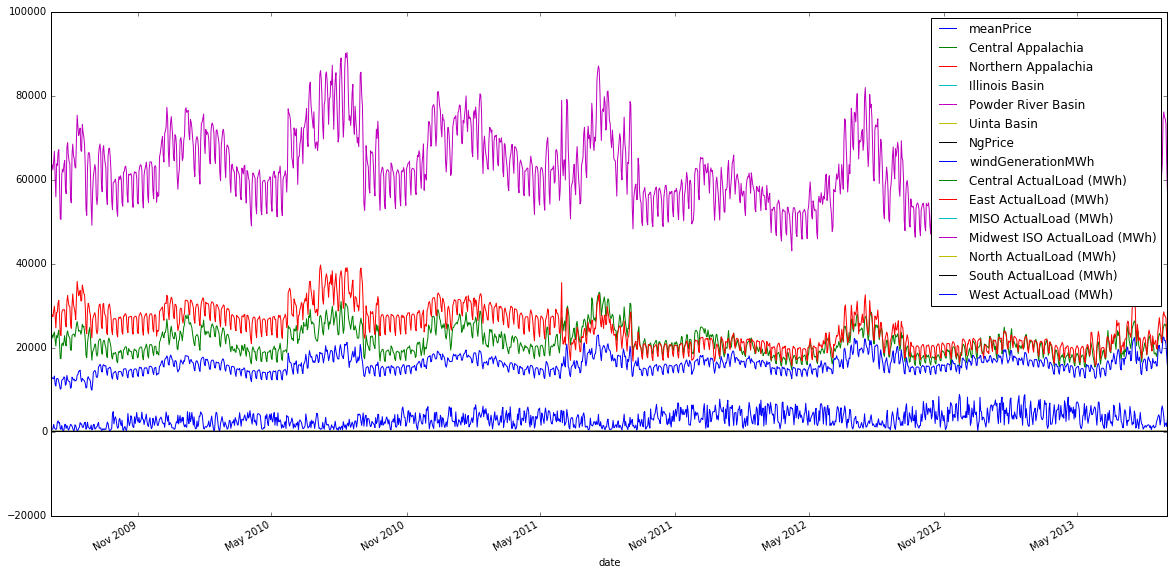

In [7]:
df = pd.merge(dfY, dfX, left_index=True, right_index=True, how='inner')
df = df[:'2013-09-01']
df.plot()

## Ridge Regression

In [29]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('meanPrice', axis=1), df['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  100.0

R2 Score:  0.0202418495039
Explained Variance Score:  0.0204183628498
MAE:  13.2460046859
MSE:  228.650465338
Median AE:  11.7063520909



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
5,NgPrice,2.096708
1,Northern Appalachia,0.242394
2,Illinois Basin,0.128549
0,Central Appalachia,0.006675
8,East ActualLoad (MWh),0.000281
7,Central ActualLoad (MWh),0.000129
10,Midwest ISO ActualLoad (MWh),0.000041
9,MISO ActualLoad (MWh),0.000000
11,North ActualLoad (MWh),0.000000
12,South ActualLoad (MWh),0.000000


## LASSO Regression

In [26]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('meanPrice', axis=1), df['meanPrice'], 
                                                    test_size=0.2, random_state=0)

# Train
lasso = linear_model.LassoCV(alphas=[5e2, 8e2, 9e2, 1e3, 2e3, 3e3, 4e3, 5e3, 1e4], cv=5)
fit = lasso.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  1000.0

R2 Score:  0.0202418495039
Explained Variance Score:  0.0204183628498
MAE:  13.2460046859
MSE:  228.650465338
Median AE:  11.7063520909



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
10,Midwest ISO ActualLoad (MWh),0.00018
0,Central Appalachia,0.00000
1,Northern Appalachia,0.00000
2,Illinois Basin,0.00000
3,Powder River Basin,0.00000
4,Uinta Basin,0.00000
5,NgPrice,0.00000
6,windGenerationMWh,-0.00000
7,Central ActualLoad (MWh),0.00000
8,East ActualLoad (MWh),0.00000


## Ridge Regression (Log Transformed)
### Log Transformed: LMP

In [30]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Log transform
df2 = df.copy()
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  100.0

R2 Score:  0.0177921201329
Explained Variance Score:  0.0179159554688
MAE:  0.209531608125
MSE:  0.0536983134013
Median AE:  0.18344248877



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
5,NgPrice,2.559917e-02
1,Northern Appalachia,3.161279e-03
2,Illinois Basin,5.893969e-04
7,Central ActualLoad (MWh),2.973340e-06
8,East ActualLoad (MWh),2.306106e-06
10,Midwest ISO ActualLoad (MWh),4.245918e-07
9,MISO ActualLoad (MWh),0.000000e+00
11,North ActualLoad (MWh),0.000000e+00
12,South ActualLoad (MWh),0.000000e+00
6,windGenerationMWh,-1.305289e-06


## Ridge Regression (Log Transformed)
### Log Transformed: LMP, NgPrice

In [31]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Log transform
df2 = df.copy()
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)
df2['NgPrice'] = np.log(df2['NgPrice'])


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  10.0

R2 Score:  0.017050841812
Explained Variance Score:  0.0171476846511
MAE:  0.209457908053
MSE:  0.0537388398484
Median AE:  0.182185240627



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
5,NgPrice,8.854742e-02
1,Northern Appalachia,3.293073e-03
2,Illinois Basin,1.031080e-03
7,Central ActualLoad (MWh),3.204052e-06
8,East ActualLoad (MWh),2.464107e-06
10,Midwest ISO ActualLoad (MWh),4.308270e-07
9,MISO ActualLoad (MWh),0.000000e+00
11,North ActualLoad (MWh),0.000000e+00
12,South ActualLoad (MWh),0.000000e+00
6,windGenerationMWh,-1.197610e-06


## Ridge Regression (Log Transformed)
### Log Transformed: NgPrice

In [33]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Log transform
df2 = df.copy()
df2['NgPrice'] = np.log(df2['NgPrice'])


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  10.0

R2 Score:  0.0191680925676
Explained Variance Score:  0.0193027665293
MAE:  13.2394175653
MSE:  228.901052713
Median AE:  11.6415346686



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
5,NgPrice,7.366182
1,Northern Appalachia,0.254393
2,Illinois Basin,0.168205
8,East ActualLoad (MWh),0.000295
7,Central ActualLoad (MWh),0.000146
10,Midwest ISO ActualLoad (MWh),0.000042
9,MISO ActualLoad (MWh),0.000000
11,North ActualLoad (MWh),0.000000
12,South ActualLoad (MWh),0.000000
6,windGenerationMWh,-0.000113


## Ridge Regression (Log Transformed)
### Log Transformed: NgPrice, Electricity Demands

In [34]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Log transform
df2 = df.copy()
df2['NgPrice'] = np.log(df2['NgPrice'])


# Log Transform - Translate actual loads by tiny amount to avoid np.log(0)
df2['Central ActualLoad (MWh)'] = np.log(df2['Central ActualLoad (MWh)'] + 0.1)
df2['Midwest ISO ActualLoad (MWh)'] = np.log(df2['Midwest ISO ActualLoad (MWh)'] + 0.1)
df2['East ActualLoad (MWh)'] = np.log(df2['East ActualLoad (MWh)'] + 0.1)
df2['MISO ActualLoad (MWh)'] = np.log(df2['MISO ActualLoad (MWh)'] + 0.1)
df2['North ActualLoad (MWh)'] = np.log(df2['North ActualLoad (MWh)'] + 0.1)
df2['South ActualLoad (MWh)'] = np.log(df2['South ActualLoad (MWh)'] + 0.1)
df2['West ActualLoad (MWh)'] = np.log(df2['West ActualLoad (MWh)'] + 0.1)


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  10.0

R2 Score:  0.0177826210818
Explained Variance Score:  0.0179282874011
MAE:  13.2532797196
MSE:  229.224386282
Median AE:  11.6232508378



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:44: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
5,NgPrice,7.542351e+00
8,East ActualLoad (MWh),5.765711e+00
10,Midwest ISO ActualLoad (MWh),1.841562e+00
7,Central ActualLoad (MWh),1.801339e+00
1,Northern Appalachia,2.411703e-01
2,Illinois Basin,1.459575e-01
12,South ActualLoad (MWh),1.491898e-27
9,MISO ActualLoad (MWh),1.490672e-27
11,North ActualLoad (MWh),1.490672e-27
6,windGenerationMWh,-1.454791e-04


## Ridge Regression (Log Transformed)
### Log Transformed: LMP, NgPrice, Electricity Demands

In [35]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Log transform
df2 = df.copy()
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)
df2['NgPrice'] = np.log(df2['NgPrice'])


# Log Transform - Translate actual loads by tiny amount to avoid np.log(0)
df2['Central ActualLoad (MWh)'] = np.log(df2['Central ActualLoad (MWh)'] + 0.1)
df2['Midwest ISO ActualLoad (MWh)'] = np.log(df2['Midwest ISO ActualLoad (MWh)'] + 0.1)
df2['East ActualLoad (MWh)'] = np.log(df2['East ActualLoad (MWh)'] + 0.1)
df2['MISO ActualLoad (MWh)'] = np.log(df2['MISO ActualLoad (MWh)'] + 0.1)
df2['North ActualLoad (MWh)'] = np.log(df2['North ActualLoad (MWh)'] + 0.1)
df2['South ActualLoad (MWh)'] = np.log(df2['South ActualLoad (MWh)'] + 0.1)
df2['West ActualLoad (MWh)'] = np.log(df2['West ActualLoad (MWh)'] + 0.1)


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  10.0

R2 Score:  0.0150715164705
Explained Variance Score:  0.0151798028007
MAE:  0.209687168635
MSE:  0.0538470515973
Median AE:  0.180897695253



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:45: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
5,NgPrice,9.173686e-02
8,East ActualLoad (MWh),4.946854e-02
7,Central ActualLoad (MWh),3.958474e-02
10,Midwest ISO ActualLoad (MWh),1.928481e-02
1,Northern Appalachia,3.166645e-03
2,Illinois Basin,9.439736e-04
12,South ActualLoad (MWh),6.970375e-29
9,MISO ActualLoad (MWh),6.967910e-29
11,North ActualLoad (MWh),6.967910e-29
6,windGenerationMWh,-1.715082e-06


## Ridge Regression (Log Transformed)
### Log Transformed: LMP, NgPrice, Coal

In [39]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Log transform
df2 = df.copy()
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)
df2['NgPrice'] = np.log(df2['NgPrice'])


# Log Transform - Translate actual loads by tiny amount to avoid np.log(0)
df2['Northern Appalachia'] = np.log(df2['Northern Appalachia'] + 0.1)
df2['Illinois Basin'] = np.log(df2['Illinois Basin'] + 0.1)
df2['Uinta Basin'] = np.log(df2['Uinta Basin'] + 0.1)
df2['Central Appalachia'] = np.log(df2['Central Appalachia'] + 0.1)


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  1.0

R2 Score:  0.0173361931524
Explained Variance Score:  0.0174288286599
MAE:  0.209420960417
MSE:  0.0537232393976
Median AE:  0.182883204692



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
1,Northern Appalachia,1.855942e-01
5,NgPrice,9.519200e-02
2,Illinois Basin,4.503410e-02
7,Central ActualLoad (MWh),3.227884e-06
8,East ActualLoad (MWh),2.252460e-06
10,Midwest ISO ActualLoad (MWh),4.450854e-07
9,MISO ActualLoad (MWh),0.000000e+00
11,North ActualLoad (MWh),0.000000e+00
12,South ActualLoad (MWh),0.000000e+00
6,windGenerationMWh,-1.269426e-06


## Ridge Regression (Log Transformed)
### Log Transformed: LMP, NgPrice, Coal, Electricity Demands

In [36]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Log transform
df2 = df.copy()
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)
df2['NgPrice'] = np.log(df2['NgPrice'])


# Log Transform - Translate actual loads by tiny amount to avoid np.log(0)
df2['Central ActualLoad (MWh)'] = np.log(df2['Central ActualLoad (MWh)'] + 0.1)
df2['Midwest ISO ActualLoad (MWh)'] = np.log(df2['Midwest ISO ActualLoad (MWh)'] + 0.1)
df2['East ActualLoad (MWh)'] = np.log(df2['East ActualLoad (MWh)'] + 0.1)
df2['MISO ActualLoad (MWh)'] = np.log(df2['MISO ActualLoad (MWh)'] + 0.1)
df2['North ActualLoad (MWh)'] = np.log(df2['North ActualLoad (MWh)'] + 0.1)
df2['South ActualLoad (MWh)'] = np.log(df2['South ActualLoad (MWh)'] + 0.1)
df2['West ActualLoad (MWh)'] = np.log(df2['West ActualLoad (MWh)'] + 0.1)

df2['Northern Appalachia'] = np.log(df2['Northern Appalachia'] + 0.1)
df2['Illinois Basin'] = np.log(df2['Illinois Basin'] + 0.1)
df2['Uinta Basin'] = np.log(df2['Uinta Basin'] + 0.1)
df2['Central Appalachia'] = np.log(df2['Central Appalachia'] + 0.1)


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  1.0

R2 Score:  0.0161464366547
Explained Variance Score:  0.0162430763887
MAE:  0.20950329345
MSE:  0.053788284607
Median AE:  0.182348717054



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:50: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
1,Northern Appalachia,1.767101e-01
5,NgPrice,9.617137e-02
7,Central ActualLoad (MWh),7.571193e-02
8,East ActualLoad (MWh),7.098973e-02
2,Illinois Basin,4.899725e-02
9,MISO ActualLoad (MWh),9.503614e-28
11,North ActualLoad (MWh),9.503614e-28
12,South ActualLoad (MWh),9.502275e-28
6,windGenerationMWh,-1.412512e-06
3,Powder River Basin,-7.003104e-03


In [47]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Log transform
df2 = df.copy()
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)
df2['NgPrice'] = np.log(df2['NgPrice'])


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2[['NgPrice', 'NgPrice']], df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  10.0

R2 Score:  0.0131551998473
Explained Variance Score:  0.0132868670275
MAE:  0.209560479434
MSE:  0.0539518185949
Median AE:  0.17815351357



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
0,NgPrice,0.050317
1,NgPrice,0.050317


## Ridge Regression (Outlier Removal)
### Outlier: Low LMP

In [70]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Remove outlier: Very low LMP
df2 = df[df['meanPrice'] > 10]


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  10.0

R2 Score:  0.354145352553
Explained Variance Score:  0.357814755077
MAE:  5.69022125557
MSE:  78.5533537682
Median AE:  4.13413843377



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:33: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
5,NgPrice,4.459671
2,Illinois Basin,0.377086
1,Northern Appalachia,0.370209
0,Central Appalachia,0.071663
8,East ActualLoad (MWh),0.000563
10,Midwest ISO ActualLoad (MWh),0.000253
7,Central ActualLoad (MWh),0.000071
9,MISO ActualLoad (MWh),0.000000
11,North ActualLoad (MWh),0.000000
12,South ActualLoad (MWh),0.000000


## Ridge Regression (Outlier Removal)
### Outlier: Low LMP, LMP>2sd

In [73]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model
from scipy import stats


# Remove outlier: Very low LMP
df2 = df[df['meanPrice'] > 10]
df2 = df2[(np.abs(stats.zscore(df2['meanPrice'])) < 2)]



# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  1.0

R2 Score:  0.379426374609
Explained Variance Score:  0.380066734183
MAE:  4.4342100944
MSE:  37.0288459787
Median AE:  3.40487821112



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:36: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
5,NgPrice,2.614384
3,Powder River Basin,0.185896
1,Northern Appalachia,0.102010
2,Illinois Basin,0.004039
7,Central ActualLoad (MWh),0.000353
10,Midwest ISO ActualLoad (MWh),0.000303
9,MISO ActualLoad (MWh),0.000000
11,North ActualLoad (MWh),0.000000
12,South ActualLoad (MWh),0.000000
13,West ActualLoad (MWh),-0.000021


## Ridge Regression (Log Transform, Outlier Removal)
### Transform: LMP
### Outlier: Low LMP, LMP>2sd

In [80]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model
from scipy import stats


# Outlier Removal: Very low LMP
df2 = df.copy()
df2 = df2[df2['meanPrice'] > 10]


# Log Transform
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)


# Outlier Removal: 2-sd
df2 = df2[(np.abs(stats.zscore(df2['meanPrice'])) < 2)]


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  10.0

R2 Score:  0.394383351099
Explained Variance Score:  0.39531103794
MAE:  0.051055039623
MSE:  0.00515840872458
Median AE:  0.0353386686647



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:43: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
5,NgPrice,3.513347e-02
1,Northern Appalachia,2.358316e-03
7,Central ActualLoad (MWh),3.699134e-06
10,Midwest ISO ActualLoad (MWh),3.639232e-06
13,West ActualLoad (MWh),2.235397e-07
9,MISO ActualLoad (MWh),0.000000e+00
11,North ActualLoad (MWh),0.000000e+00
12,South ActualLoad (MWh),0.000000e+00
8,East ActualLoad (MWh),-2.868512e-07
6,windGenerationMWh,-7.324269e-06


## Ridge Regression (Log Transform, Outlier Removal)
### Transform: LMP, NgPrice
### Outlier: Low LMP, LMP>2sd

In [81]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model
from scipy import stats


# Outlier Removal: Very low LMP
df2 = df.copy()
df2 = df2[df2['meanPrice'] > 10]


# Log Transform
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)
df2['NgPrice'] = np.log(df2['NgPrice'])


# Outlier Removal: 2-sd
df2 = df2[(np.abs(stats.zscore(df2['meanPrice'])) < 2)]


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  1.0

R2 Score:  0.393875514551
Explained Variance Score:  0.394854612434
MAE:  0.0514086263789
MSE:  0.00516273428016
Median AE:  0.0362293436829



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:44: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
5,NgPrice,1.269050e-01
1,Northern Appalachia,2.518293e-03
3,Powder River Basin,6.060380e-04
2,Illinois Basin,4.812814e-04
7,Central ActualLoad (MWh),3.901244e-06
10,Midwest ISO ActualLoad (MWh),3.647761e-06
9,MISO ActualLoad (MWh),0.000000e+00
11,North ActualLoad (MWh),0.000000e+00
12,South ActualLoad (MWh),0.000000e+00
8,East ActualLoad (MWh),-1.039335e-07


## Ridge Regression (Log Transform, Outlier Removal)
### Transform: LMP, NgPrice, Coal
### Outlier: Low LMP, LMP>2sd

In [108]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model
from scipy import stats


# Outlier Removal: Very low LMP
df2 = df.copy()
df2 = df2[df2['meanPrice'] > 10]


# Log Transform
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)
df2['NgPrice'] = np.log(df2['NgPrice'])


# Log Transform - Translate by tiny amount to avoid np.log(0)
df2['Northern Appalachia'] = np.log(df2['Northern Appalachia'] + 0.1)
df2['Illinois Basin'] = np.log(df2['Illinois Basin'] + 0.1)
df2['Uinta Basin'] = np.log(df2['Uinta Basin'] + 0.1)
df2['Powder River Basin'] = np.log(df2['Uinta Basin'] + 0.1)
df2['Central Appalachia'] = np.log(df2['Central Appalachia'] + 0.1)


# Outlier Removal: 2-sd
df2 = df2[(np.abs(stats.zscore(df2['meanPrice'])) < 2)]


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  0.1

R2 Score:  0.394110576964
Explained Variance Score:  0.395112473891
MAE:  0.0513784652985
MSE:  0.00516073210931
Median AE:  0.0367019297739



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:52: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
1,Northern Appalachia,1.632450e-01
5,NgPrice,1.297210e-01
2,Illinois Basin,1.183698e-02
10,Midwest ISO ActualLoad (MWh),3.759377e-06
7,Central ActualLoad (MWh),3.697204e-06
9,MISO ActualLoad (MWh),0.000000e+00
11,North ActualLoad (MWh),0.000000e+00
12,South ActualLoad (MWh),0.000000e+00
13,West ActualLoad (MWh),-4.238436e-08
8,East ActualLoad (MWh),-3.385104e-07


## Ridge Regression (Log Transform, Outlier Removal)
### Transform: LMP, NgPrice, Coal
### Outlier: Low LMP(under15), LMP>2sd

In [107]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model
from scipy import stats


# Outlier Removal: Very low LMP
df2 = df.copy()
df2 = df2[df2['meanPrice'] > 15]


# Log Transform
df2['meanPrice'] = np.log(df2['meanPrice'] + 50)
df2['NgPrice'] = np.log(df2['NgPrice'])


# Log Transform - Translate by tiny amount to avoid np.log(0)
df2['Northern Appalachia'] = np.log(df2['Northern Appalachia'] + 0.1)
df2['Illinois Basin'] = np.log(df2['Illinois Basin'] + 0.1)
df2['Uinta Basin'] = np.log(df2['Uinta Basin'] + 0.1)
df2['Powder River Basin'] = np.log(df2['Uinta Basin'] + 0.1)
df2['Central Appalachia'] = np.log(df2['Central Appalachia'] + 0.1)


# Outlier Removal: 2-sd
df2 = df2[(np.abs(stats.zscore(df2['meanPrice'])) < 2)]


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop('meanPrice', axis=1), df2['meanPrice'], 
                                                    test_size=0.2, random_state=0)


# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  0.1

R2 Score:  0.494348529134
Explained Variance Score:  0.49575329254
MAE:  0.0475467139593
MSE:  0.00378222186221
Median AE:  0.038334346962



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:52: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
1,Northern Appalachia,1.447708e-01
5,NgPrice,1.377098e-01
2,Illinois Basin,2.435234e-02
7,Central ActualLoad (MWh),4.187887e-06
10,Midwest ISO ActualLoad (MWh),3.135262e-06
8,East ActualLoad (MWh),3.009055e-07
9,MISO ActualLoad (MWh),0.000000e+00
11,North ActualLoad (MWh),0.000000e+00
12,South ActualLoad (MWh),0.000000e+00
13,West ActualLoad (MWh),-1.401148e-06
